In [11]:
import pyopenpose as op
import cv2
import time
import numpy as np
import os
import json
import sys

from matplotlib import pyplot as plt
from tqdm import tqdm

try:
    from myOpenpose import *
    from transform import *
except:
    sys.path.append('/home/nmiguens/Python')
    from myOpenpose import *
    from transform import *

In [12]:
# Split du fichier txt d'annotations

path = "/home/nmiguens/Datasets/ph2014-dev-set-handshape-annotations"
annotations = open(os.path.join(path,"3359-ph2014-MS-handshape-annotations.txt"), "r").read()
annotations_lignes = annotations.split("\n")

print(annotations_lignes[0].split(" "))

with open(os.path.join(path,'RWTH_words_count.txt')) as json_file:
    words_count = json.load(json_file)
    
words_count["1"]

['images/final_phoenix_noPause_noCompound_lefthandtag_noClean/01February_2011_Tuesday_heute_default-8/1/*.png_fn000030-0.png', 'write']


528

In [13]:
## Process Image -> Keypoints

# Seuil du nombre d'échantillon par classe
threshold = 30

# Chemin des fichiers JSON
JSONpath = "/home/nmiguens/JSON/RWTH-PHOENIX_hand_OptimizedParam"

start = time.time()

X = []
y = []
images = []
convertionTab = []

for imageId in tqdm(range(len(annotations_lignes))):

    imagePath, imageClass = annotations_lignes[imageId].split(" ")
    
    if words_count[imageClass] >= threshold :
        
        y.append(imageClass)
    
        imagePath = os.path.join(path, imagePath)
        images.append(imagePath)
        
        jsonFile = os.path.join(JSONpath, "{}_keypoints.json".format(imageId))
        x = json_2_numpy(jsonFile, body = True, hand = True, face = False)
        X.append(x)
        
        convertionTab.append(imageId)
end = time.time()
print("OpenPose demo successfully finished. Total time: " + str(end - start) + " seconds")

100%|██████████| 3359/3359 [00:12<00:00, 274.17it/s]

OpenPose demo successfully finished. Total time: 12.256145715713501 seconds


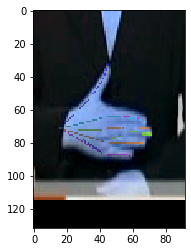

In [14]:
# Exemple de pose

imageId = 302

params = set_params(body = 0, hand = True, hand_detector = 2, hand_opti = True)
datum = opImage_display(images[imageId], params)

In [15]:
# Split in train and test set
from sklearn.model_selection import train_test_split

X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
def get_accuracy(y_test, y):
    return np.sum(y == y_test)/y.shape[0]

get_accuracy(np.array([1,2,3]), np.array([1,3,3]))

0.6666666666666666

In [17]:
# SVMs
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC, LinearSVC

# SVC
clf = make_pipeline(StandardScaler(), SVC())
classifier = clf.fit(X_train, y_train)
y_res = clf.predict(X_test)
print("SVC accuracy : ", get_accuracy(y_test, y_res))

SVC accuracy :  0.7380952380952381


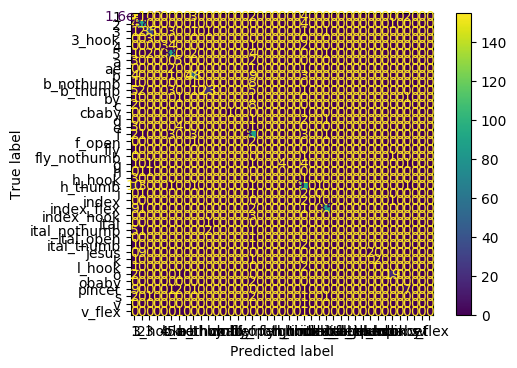

In [18]:
from sklearn.metrics import plot_confusion_matrix

disp1 = plot_confusion_matrix(classifier, X_test, y_test)
# print(disp.confusion_matrix)
disp1.figure_.dpi = 100
plt.show()

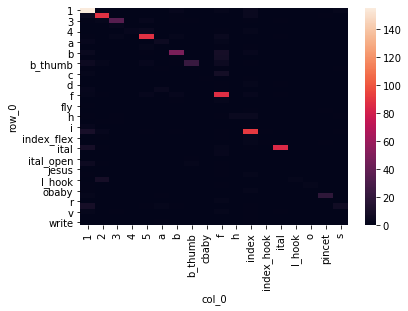

In [19]:
import pandas as pd
import seaborn as sn

confusion_matrix = pd.crosstab(y_test, y_res)
sn.heatmap(confusion_matrix, annot=False)
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score

clf = make_pipeline(StandardScaler(), SVC())
scores = cross_val_score(clf, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy: 0.77 (+/- 0.14)
